In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

csv_path = "./MDNVE_MCNVT/"
phases = ["Solid", "Liquid", "Gas"]
phases_path = [phase + "/" for phase in phases]

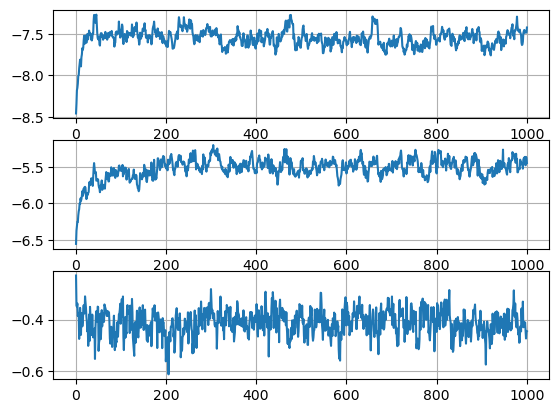

In [84]:
# Temperature is already eq'd with Metropolis algorithm => analyse epot equilibration

eq_path = csv_path + "NonEq/"
eq_directories = map(os.fsencode, [eq_path + phase for phase in phases_path])

for idx, directory in enumerate(eq_directories):

    plt.subplot(3, 1, idx + 1)
    plt.grid(True)

    filename = "output_epot.dat"
    eq_data = np.loadtxt(os.fsdecode(directory) + filename)

    plt.plot(eq_data[:, 0], eq_data[:, 1])

plt.show()

In [85]:
# Reference: Lec. 6, slide 30

M = int(5e5)
t_max = M
t_blk_max = int(1e2)    # TODO increase this to 1e3

def Autcorr(in_data):

    chi = []

    for t in range(0, t_blk_max):

        sum_a = 0.0
        sum_b = 0.0
        sum_c = 0.0
        sum_d = 0.0
        sum_e = 0.0

        for i in range(0, t_max - t):

            sum_a += (in_data[i] * in_data[i + t])
            sum_b += in_data[i]
            sum_c += in_data[i + t]
            sum_d += in_data[i] ** 2
            sum_e += in_data[i]

        # Do not loop over the whole t_max range => improved efficiency

        for i in range(t_max - t, t_max):

            sum_d += in_data[i] ** 2
            sum_e += in_data[i]

        idelta_t = 1.0 / (t_max - t)
        chi_t = idelta_t * (sum_a - sum_b * idelta_t * sum_c) / (1.0 / t_max * (sum_d - 1.0 / t_max * (sum_e ** 2)))
        chi.append(chi_t)

    return np.asarray(chi)

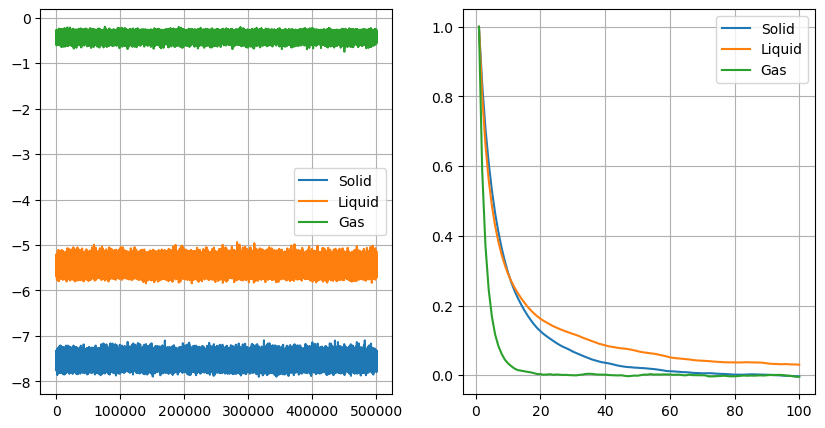

In [86]:
autocorr_path = csv_path + "AutoCorr/"
autocorr_directories = map(os.fsencode, [autocorr_path + phase for phase in phases_path])

autocorr_func_path = "./PythonData/"

plt.figure(figsize=(10,5))

for idx, directory in enumerate(autocorr_directories):

    filename_data = "output_epot.dat"
    filename_autocorr = "output_autocorr.dat"
    autocorr_data = np.loadtxt(os.fsdecode(directory) + filename_data)

    plt.subplot(1, 2, 1)
    plt.plot(autocorr_data[:, 0], autocorr_data[:, 1], label = phases[idx])
    plt.grid(True)
    plt.legend()

    # Autocorr is a computationally heavy function => save data to speed up code execution

    autocorr = []
    autocorr_file_path = autocorr_func_path + phases_path[idx] + filename_autocorr

    if(os.path.isfile(os.fsencode(autocorr_file_path))):
        
        autocorr = np.loadtxt(autocorr_file_path)

    else:

        autocorr = Autcorr(autocorr_data[:, 1])
        np.savetxt(autocorr_file_path, autocorr)

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, t_blk_max + 1), autocorr, label = phases[idx])
    plt.grid(True)
    plt.legend()

plt.show()

In [87]:
def Error(sum, sum2, iblk):

    return math.sqrt(abs(sum2 - sum ** 2) / iblk)

# No need to calculate the error for each block, but only the last block error

def ComputeFinalBlockError(in_data, M, L):

    N = int(M / L)       # Number of blocks

    sum = 0.0
    sum2 = 0.0

    for i in range(0, N):

        # Faster than for loop
        blk_avg = np.sum(in_data[(i * L):((i + 1) * L - 1)]) / L

        sum += blk_avg 
        sum2 += (blk_avg ** 2)

    sum /= N
    sum2 /= N

    return Error(sum, sum2, N)


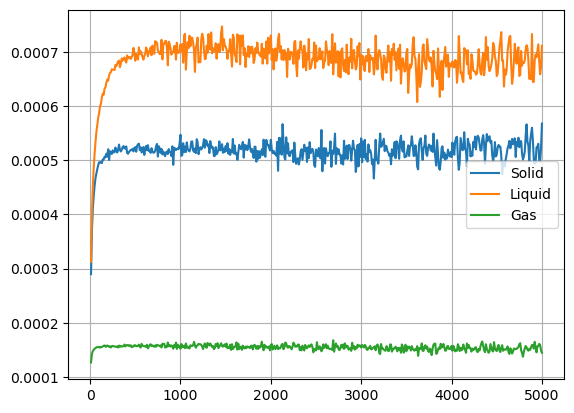

In [88]:
L_min = 10
L_max = int(5e3)
L_range = range(L_min, L_max + 1, 10)       # Step 10 not to overcrowd graph

autocorr_directories = map(os.fsencode, [autocorr_path + phase for phase in phases_path])

for idx, directory in enumerate(autocorr_directories):

    filename_data = "output_epot.dat"
    autocorr_data = np.loadtxt(os.fsdecode(directory) + filename_data)

    last_blk_errors = []

    for L in L_range:

        last_blk_errors.append(ComputeFinalBlockError(autocorr_data[:, 1], M, L))

    plt.plot(L_range, last_blk_errors, label = phases[idx])
    plt.grid(True)
    plt.legend()
#    plt.show()

plt.show()

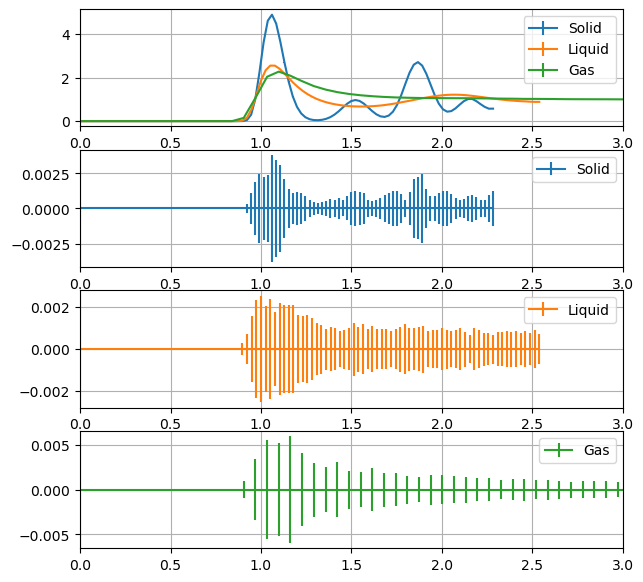

In [89]:
eqd_path = csv_path + "Eq/"
eqd_directories = map(os.fsencode, [eqd_path + phase for phase in phases_path])

plt.figure(figsize=(7,7))
colors = ['tab:blue', 'tab:orange', 'tab:green']

nbins = 100

for idx, directory in enumerate(eqd_directories):

    gr_data = np.loadtxt(os.fsdecode(directory) + "output_gr.dat")

    ax1 = plt.subplot(4, 1, 1)
    plt.errorbar(gr_data[0, :], gr_data[1, :], yerr = gr_data[2, :], label = phases[idx])
    plt.grid(True)
    plt.legend()
    # Gas phase graph extends asymptotically towards g(r) = 1
    plt.xlim(0, 3.0)

    # Graph error bars separately (too small to be seen in main graph)
    plt.subplot(4, 1, 2 + idx, sharex = ax1)
    plt.errorbar(gr_data[0, :], np.zeros(nbins), yerr = gr_data[2, :], label = phases[idx], color = colors[idx])
    plt.grid(True)
    plt.legend()

plt.show()

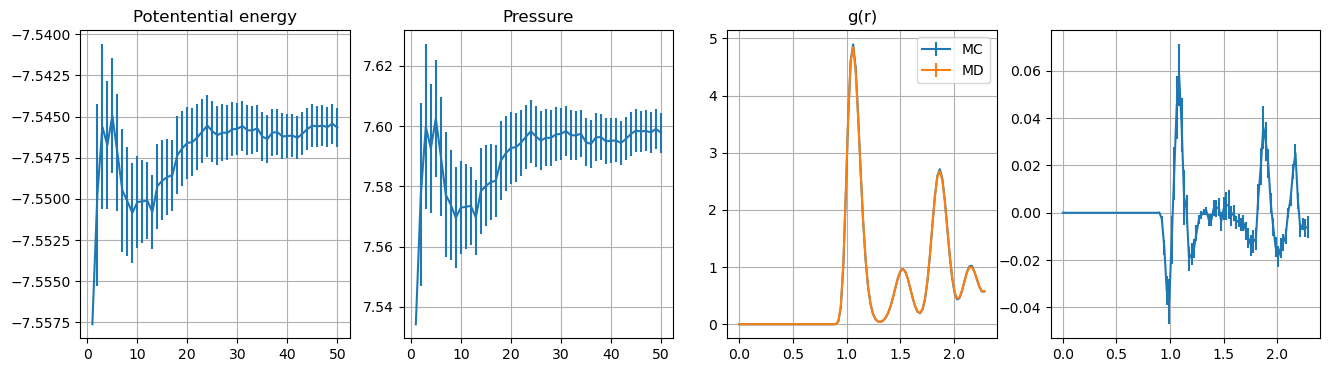

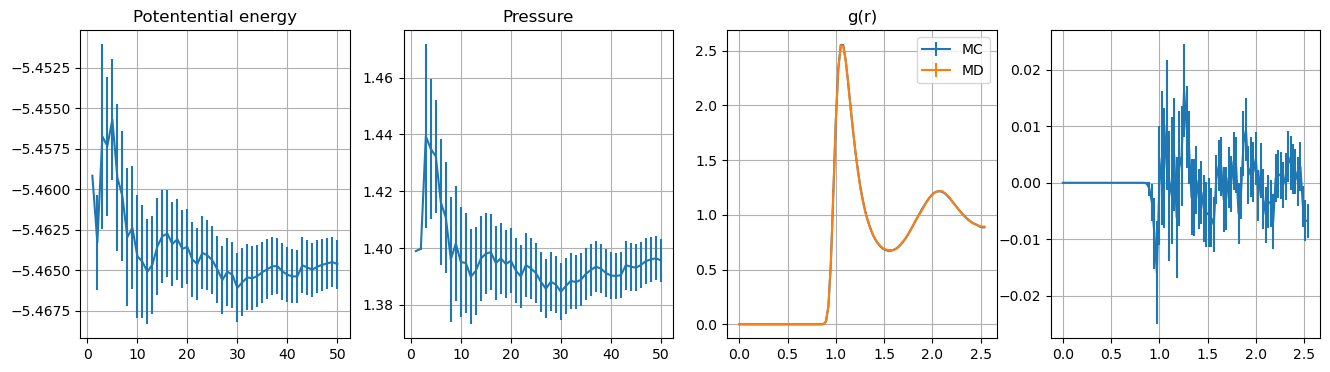

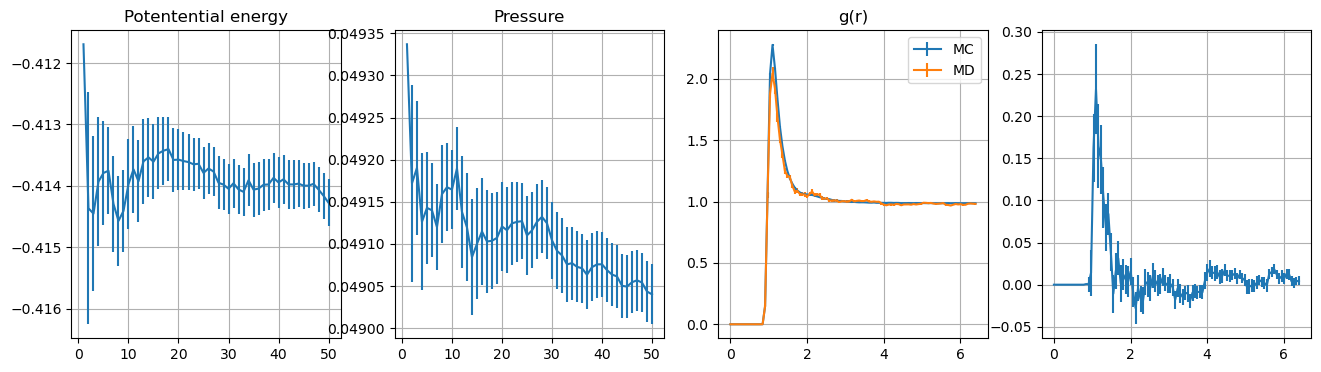

In [90]:
ar_path = csv_path + "ArSim/"
sample_meth = ["MC", "MD"]
sample_meth_path = [smet + "/" for smet in sample_meth]
titles = ["Potentential energy", "Pressure"]
file_names = ["output_epot.dat", "output_pres.dat"]

for idx, phase in enumerate(phases_path):

    plt.figure(figsize=(16,4))
    
    for gidx, fname in enumerate(file_names):

        data_path = ar_path + sample_meth_path[0] + "Eq/" + phase
        data = np.loadtxt(data_path + fname)

        plt.subplot(1, 4, gidx + 1)
        plt.errorbar(data[:,0], data[:,2], yerr=data[:,3])
        plt.grid(True)
        plt.title(titles[gidx])

    gr_complete_data = []

    for smidx, smet in enumerate(sample_meth_path):

        data_path = ar_path + smet + "Eq/" + phase

        gr_data = np.loadtxt(data_path + "output_gr.dat")
        gr_complete_data.append(gr_data)
        plt.subplot(1, 4, 3)
        plt.errorbar(gr_data[0, :], gr_data[1, :], yerr = gr_data[2, :], label = sample_meth[smidx])
        plt.grid(True)
        plt.title("g(r)")
        plt.legend()

    # Error in difference between g(r) given by sum of errors, since this is the maximum allowed error

    plt.subplot(1, 4, 4)
    gr_diff = gr_complete_data[0][1, :] - gr_complete_data[1][1, :]
    gr_diff_err = gr_complete_data[0][2, :] + gr_complete_data[1][2, :]
    plt.errorbar(gr_complete_data[0][0, :], gr_diff, yerr = gr_diff_err)
    plt.grid(True)



    plt.show()